# ノイズあり(10%)でのCifar10 - resnet32 の実験

In [1]:
!cd ../ && pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/kitamura/work/DeepLearning/NoisyData
  Running setup.py develop for noisydata


In [1]:
import tensorflow as tf
from noisydata.data_utils import CIFAR10Data
from noisydata.resnet import PreActResNet32
from noisydata.loss import LabelOptimLoss
from noisydata.plot import plot_csv

In [2]:
tf.config.experimental.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## model, loss, dataset, optimizerの設定

In [2]:
cifar10_data = CIFAR10Data()
data = cifar10_data.get_noisy_data(subtract_mean=True, noise_ratio=0.1)

weight_decay = 1e-4
lr = 1e-1
num_classes = 10

model = PreActResNet32(
    classes=num_classes,
    input_shape=data[0].shape[1:],
    weight_decay=weight_decay
)

opt = tf.keras.optimizers.Adam()
lr = 0.001

loss_fun = LabelOptimLoss()

## 動作確認

In [3]:
from noisydata.solver import Solver
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

model.compile(
    loss=loss_fun, optimizer=opt, metrics=["accuracy"])
#model.summary()

def lr_scheduler(epoch):
    new_lr = lr * (0.1 ** (epoch // 10))
    return new_lr

solver = Solver(model, data)
solver.fit(epochs=40, batch_size=128, data_augmentation=True, lr_scheduler=lr_scheduler)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
313/313 [==============================] - 18s 56ms/step - loss: 2.0384 - accuracy: 0.4126 - val_loss: 3.2319 - val_accuracy: 0.3515 - lr: 0.0010
Epoch 2/40
313/313 [==============================] - 17s 54ms/step - loss: 1.6751 - accuracy: 0.5550 - val_loss: 2.1245 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 3/40
313/313 [==============================] - 17s 54ms/step - loss: 1.5346 - accuracy: 0.6050 - val_loss: 1.8223 - val_accuracy: 0.5593 - lr: 0.0010
Epoch 4/40
313/313 [==============================] - 17s 54ms/step - loss: 1.4426 - accuracy: 0.6386 - val_loss: 1.6794 - val_accuracy: 0.6117 - lr: 0.0010
Epoch 5/40
313/313 [==============================] - 17s 54ms/step - loss: 1.3585 - accuracy: 0.6715 - val_loss: 1.6669 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 6/40
313/313 [==============================] - 17s 54ms/step - loss: 1.3029 - accuracy: 0.6957 - val_loss: 2.6205 - val_accuracy: 0.

## ラベル修正なしで学習

In [5]:
from noisydata.solver import Solver
from noisydata.utility import run_debug
from noisydata.callback import HandleNoisyLabel
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

def lr_scheduler(epoch):
    if epoch < 40: 
        new_lr = lr * (0.1 ** (epoch // 10))
    elif epoch < 80:
        new_lr = lr * (0.1 ** ((epoch - 40) // 10))
    else:
        new_lr = lr * (0.1 ** ((epoch - 80) // 10))
        
    return new_lr

solver = Solver(model, data, loss_fun, opt)
# run_debug(
#     lambda: solver.train(epochs=120, batch_size=128, lr_scheduler=lr_scheduler)
# )

In [6]:
solver.test("/home/kitamura/work/DeepLearning/NoisyData/results/20201121_102518/models/best_acc.hdf5")

313/313 [==============================] - 2s 5ms/step - loss: 1.5244 - accuracy: 0.8784
test data loss = 1.52, acc = 0.8784


In [7]:
solver.test("/home/kitamura/work/DeepLearning/NoisyData/results/20201121_102518/models/best_loss.hdf5")

313/313 [==============================] - 2s 5ms/step - loss: 1.5244 - accuracy: 0.8784
test data loss = 1.52, acc = 0.8784


In [8]:
solver.test("/home/kitamura/work/DeepLearning/NoisyData/results/20201121_102518/models/last_epoch.hdf5")

313/313 [==============================] - 2s 5ms/step - loss: 1.9917 - accuracy: 0.8692
test data loss = 1.99, acc = 0.8692


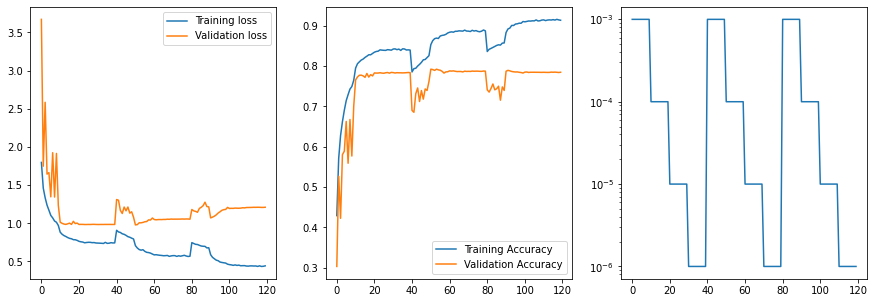

In [2]:
plot_csv("/home/kitamura/work/DeepLearning/NoisyData/results/20201121_102518/csv/train_log.csv")

In [3]:
from noisydata.solver import Solver
from noisydata.utility import run_debug
from noisydata.callback import HandleNoisyLabel
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

def lr_scheduler(epoch):
    if epoch < 40: 
        new_lr = lr * (0.1 ** (epoch // 10))
    elif epoch < 80:
        new_lr = lr * (0.1 ** ((epoch - 40) // 10))
    else:
        new_lr = lr * (0.1 ** ((epoch - 80) // 10))
        
    return new_lr

label_cb = HandleNoisyLabel(data, min_epoch=40, max_epoch=80, n_accumulate=10, update_label=True)

transfered_weights = "/home/kitamura/work/DeepLearning/NoisyData/results/20201121_102518/models/best_acc.hdf5"
solver = Solver(model, data, loss_fun, opt, callbacks=[label_cb], 
                start_epoch=30, weights_path=transfered_weights)
run_debug(
    lambda: solver.train(epochs=120, batch_size=128, lr_scheduler=lr_scheduler)
)

[2020-11-21 12:09:41 (function load_weights in file ../noisydata/solver.py at line 59)] load weigths of /home/kitamura/work/DeepLearning/NoisyData/results/20201121_102518/models/best_acc.hdf5
[2020-11-21 12:09:41 (function on_train_begin in file ../noisydata/callback.py at line 60)] Model         = PreActResNet32
[2020-11-21 12:09:41 (function on_train_begin in file ../noisydata/callback.py at line 61)] Optimizer     = Adam
[2020-11-21 12:09:41 (function on_train_begin in file ../noisydata/callback.py at line 62)] Loss function = LabelOptimLoss
[2020-11-21 12:09:41 (function on_train_begin in file ../noisydata/callback.py at line 64)] Train / Val   = 40000 / 10000
[2020-11-21 12:09:41 (function on_train_begin in file ../noisydata/callback.py at line 66)] Batch size    = 128
[2020-11-21 12:10:06 (function on_epoch_end in file ../noisydata/callback.py at line 195)] Ground Truth Val accuracy : 0.930
[2020-11-21 12:10:10 (function on_epoch_end in file ../noisydata/callback.py at line 227)]

In [7]:
import os
dirname = "/home/kitamura/work/DeepLearning/NoisyData/results/20201121_120941/models/"
solver.test(os.path.join(dirname, "best_acc.hdf5"))

313/313 [==============================] - 2s 5ms/step - loss: 1.8407 - accuracy: 0.8878
test data loss = 1.84, acc = 0.8878


In [8]:
import os
dirname = "/home/kitamura/work/DeepLearning/NoisyData/results/20201121_120941/models/"
solver.test(os.path.join(dirname, "best_loss.hdf5"))

313/313 [==============================] - 2s 5ms/step - loss: 1.8400 - accuracy: 0.8871
test data loss = 1.84, acc = 0.8871


In [9]:
import os
dirname = "/home/kitamura/work/DeepLearning/NoisyData/results/20201121_120941/models/"
solver.test(os.path.join(dirname, "last_epoch.hdf5"))

313/313 [==============================] - 2s 5ms/step - loss: 2.2944 - accuracy: 0.8761
test data loss = 2.29, acc = 0.8761


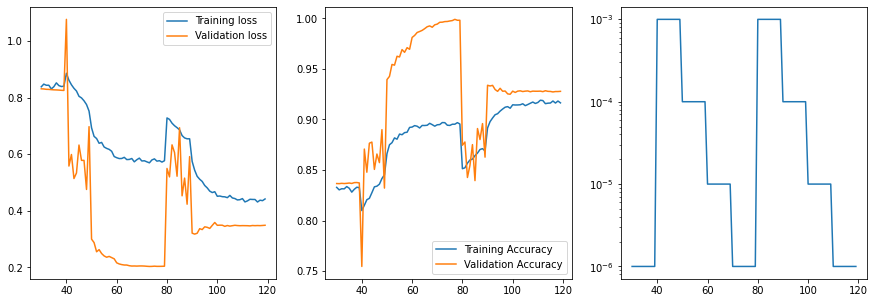

In [3]:
plot_csv("/home/kitamura/work/DeepLearning/NoisyData/results/20201121_120941/csv/train_log.csv")